# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    
    help : 'run cell',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    help_index : 'zz',
    handler : function (event) {
        
        IPython.notebook.execute_cell();
        return false; 
    }}                                               
);


<IPython.core.display.Javascript object>

In [2]:
def print_image(record):
    i = record.reshape(32,32,3)
    plt.figure(figsize=(1,1))
#     plt.subplot(1, 1, 1)
    plt.imshow(i.astype('uint8'))
#     plt.figsize(2, 2)
    plt.axis('off')
    plt.show()
    
# record = X_train[4]
# draw_image(record)
# draw_image(X_train[7])

def print_images(records):
    n = len(records)
    plt.figure(figsize=(n, 1))
    for i in range(n):
        r = records[i].reshape(32,32,3)
        plt_idx = i + 1
        plt.subplot(1, n, plt_idx)
        plt.imshow(r.astype('uint8'))
        
        plt.axis('off')
    plt.show()
# print_images(X_train[7:10], )


def to_label(x):
    d = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 
         5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck', 
        }

    return d[int(x)]

def to_labels(l):
    return [to_label(i) for i in l]

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
# # num_training = 49000
# num_training = 9800
# # num_validation = 1000
# num_validation = 200
# num_test = 1000
# # num_dev = 500
# num_dev = 300

def get_CIFAR10_data(num_training=9800, 
                     num_validation=200, 
                     num_test=1000, 
                     num_dev=300):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('dev data shape: ', X_dev.shape)
print ('dev labels shape: ', y_dev.shape)

cs231n/datasets\data_batch_1
cs231n/datasets\test_batch
Train data shape:  (9800, 3073)
Train labels shape:  (9800,)
Validation data shape:  (200, 3073)
Validation labels shape:  (200,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (300, 3073)
dev labels shape:  (300,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('loss: %f' % loss)
print ('sanity check: %f' % (-np.log(0.1)))


loss: 2.358944
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 

因为W是随机生成的, 恰巧算出正确分类的概率是0.1


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.225943 analytic: 1.225943, relative error: 3.018447e-08
numerical: -1.368443 analytic: -1.368443, relative error: 1.016857e-08
numerical: -0.845004 analytic: -0.845004, relative error: 2.533522e-08
numerical: 0.835438 analytic: 0.835438, relative error: 1.311958e-08
numerical: -0.220352 analytic: -0.220352, relative error: 1.140126e-07
numerical: -1.070160 analytic: -1.070160, relative error: 6.482273e-08
numerical: 1.932232 analytic: 1.932232, relative error: 2.713541e-08
numerical: 3.064282 analytic: 3.064282, relative error: 7.764103e-09
numerical: 1.965433 analytic: 1.965433, relative error: 1.386630e-08
numerical: -0.245304 analytic: -0.245304, relative error: 3.352541e-08
numerical: 2.544236 analytic: 2.544236, relative error: 2.644211e-09
numerical: -5.640031 analytic: -5.640031, relative error: 8.918836e-09
numerical: -1.589568 analytic: -1.589568, relative error: 2.907785e-08
numerical: 1.168545 analytic: 1.168545, relative error: 3.403136e-08
numerical: -1.342658

In [10]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print ('Gradient difference: %f' % grad_difference)

naive loss: 2.342567e+00 computed in 0.104006s
vectorized loss: 2.342567e+00 computed in 0.007001s
Loss difference: 0.000000
Gradient difference: 0.000000


In [12]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]
learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [1e4, 5e4, 1e5, 5e5, 1e6, 1e7, 1e8]

# learning_rates = learning_rates[:1]
# regularization_strengths = regularization_strengths[:1]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_iters = 500
for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        softmax = Softmax()
        
        print(' ---- train at {} {}-----'.format(learning_rate, reg_strength))
        loss_hist = softmax.train(X_train, y_train, 
                                  learning_rate=learning_rate, 
                                  reg=reg_strength,
                                  num_iters=num_iters, 
                                  verbose=False)
        print(loss_hist[::100])
        
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        
        key = learning_rate, reg_strength
        val = training_accuracy, validation_accuracy
        results[key] = val
        
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

 ---- train at 1e-08 10000.0-----
[160.13585263843004, 156.47429642919479, 153.15813727979682, 150.04040271553674, 147.239797942949]
 ---- train at 1e-08 50000.0-----
[768.53305845773741, 695.3600062744423, 628.59862509118523, 569.01777386366996, 514.75851945085071]
 ---- train at 1e-08 100000.0-----
[1547.6730840140447, 1266.886529770482, 1037.4048532536426, 848.94406453514887, 695.44515627566386]
 ---- train at 1e-08 500000.0-----
[7677.3677700124945, 2817.973134583006, 1035.079198122781, 381.08507674622069, 141.29300952449518]
 ---- train at 1e-08 1000000.0-----
[15416.742132019906, 2066.7650117263333, 278.73668219199163, 39.26994474578207, 7.234620121414693]
 ---- train at 1e-08 10000000.0-----
[151088.83596035274, 2.2962204087239284, 2.2986626294915919, 2.2994126459572906, 2.2986106497964829]
 ---- train at 1e-08 100000000.0-----
[1536889.5496306375, 2.3025748478288723, 2.3025934433433464, 2.3025473573137929, 2.3024380013231056]
 ---- train at 5e-08 10000.0-----
[161.3566070736221

D:\kaggle\CS231n_assignment1\cs231n\classifiers\softmax.py:126: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(Probs[range(num_train), y]))
D:\kaggle\CS231n_assignment1\cs231n\classifiers\softmax.py:131: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
D:\kaggle\CS231n_assignment1\cs231n\classifiers\softmax.py:131: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)


[1525834.9318874129, inf, inf, inf, inf]
 ---- train at 1e-07 10000.0-----
[158.03466863888536, 127.95101582039909, 104.48985285717548, 85.953328286065343, 70.373879521046504]
 ---- train at 1e-07 50000.0-----
[769.74248882114, 282.50907867203023, 104.65039879470839, 39.653781856808358, 15.844794527589059]
 ---- train at 1e-07 100000.0-----
[1541.1972956247937, 207.64863650075168, 29.590416779267173, 5.8116435388768721, 2.6160849209972916]
 ---- train at 1e-07 500000.0-----
[7723.7975711055506, 2.5407907204795794, 2.2432022880255609, 2.2638054168315036, 2.2532061107120249]
 ---- train at 1e-07 1000000.0-----
[15282.727196566606, 2.2843422651999292, 2.2691011159386494, 2.2754183671605914, 2.2580967185868466]
 ---- train at 1e-07 10000000.0-----
[152343.56372404733, 2.3010020513001677, 2.3021313822979499, 2.3015789064985905, 2.3010522575114036]
 ---- train at 1e-07 100000000.0-----


D:\kaggle\CS231n_assignment1\cs231n\classifiers\softmax.py:133: RuntimeWarning: overflow encountered in multiply
  dW += reg * W


[1551746.0594706598, inf, inf, inf, nan]
 ---- train at 5e-07 10000.0-----
[159.32929449000997, 58.363826106435873, 22.48637170381669, 9.4076974577197809, 4.6417640784385545]
 ---- train at 5e-07 50000.0-----
[771.00411618037981, 6.8385234252400702, 2.0700270473161395, 2.0536530816929734, 2.0372626127092923]
 ---- train at 5e-07 100000.0-----
[1536.2408163605862, 2.191668299990571, 2.1392358189305036, 2.1437046616030559, 2.1335490492308189]
 ---- train at 5e-07 500000.0-----
[7695.5634854155933, 2.2293963362804043, 2.2606246657619544, 2.2499786724390476, 2.2432957989517419]
 ---- train at 5e-07 1000000.0-----
[15260.185697330404, 2.2807706373207681, 2.2706178354967403, 2.2740712154134215, 2.2803624293031328]
 ---- train at 5e-07 10000000.0-----
[154379.04940139607, inf, inf, inf, inf]
 ---- train at 5e-07 100000000.0-----
[1532064.9717074172, inf, nan, nan, nan]
 ---- train at 1e-06 10000.0-----
[158.3799742367523, 22.10884414516169, 4.5810756592535036, 2.2842432046787771, 1.9144030130

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.368000


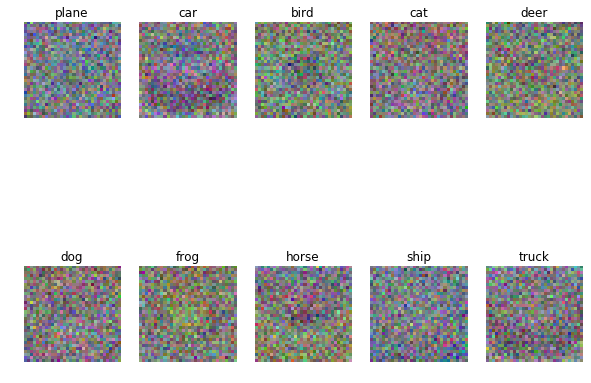

In [17]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])